Loading and preprocessing data...

Initializing detector...
Training Random Forest...
Training Deep Learning model...
Epoch [5/10], Loss: 0.2440
Epoch [10/10], Loss: 0.2245
Training Incremental Random Forest...
Model saved successfully to incremental_ddos_detector.pkl

Simulating incremental updates...
Processing chunk 21/20
Generating visualizations...


<Figure size 1200x600 with 0 Axes>

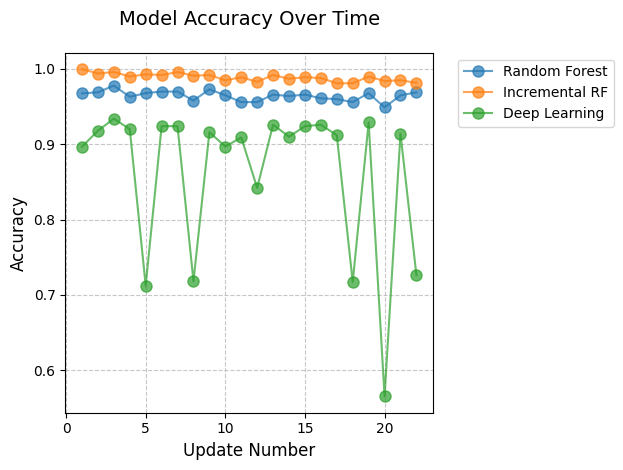

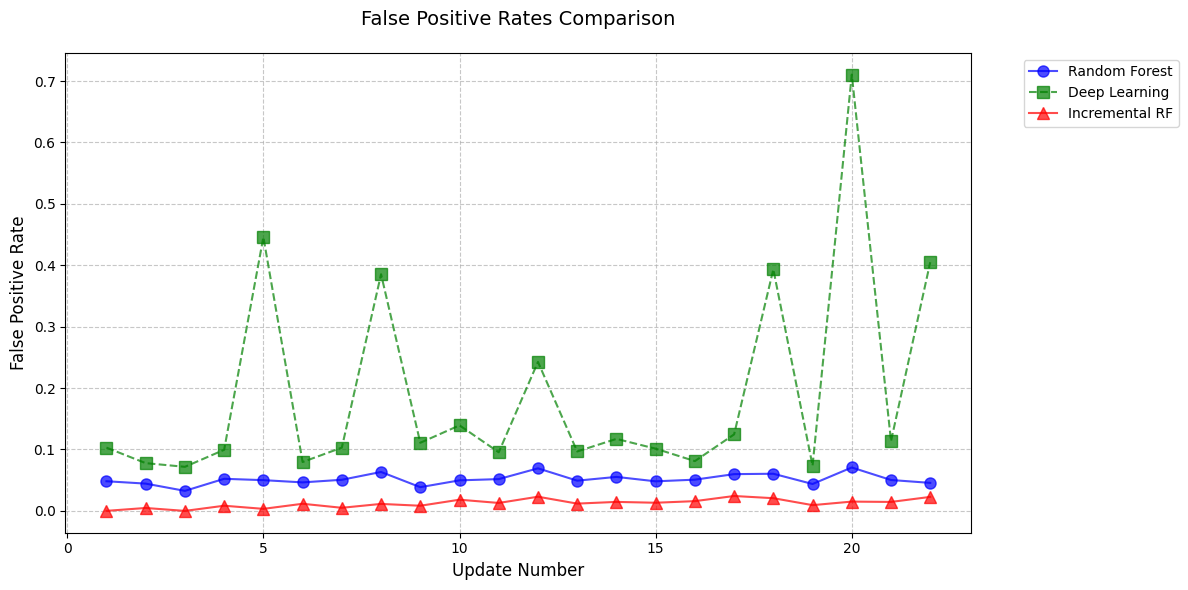

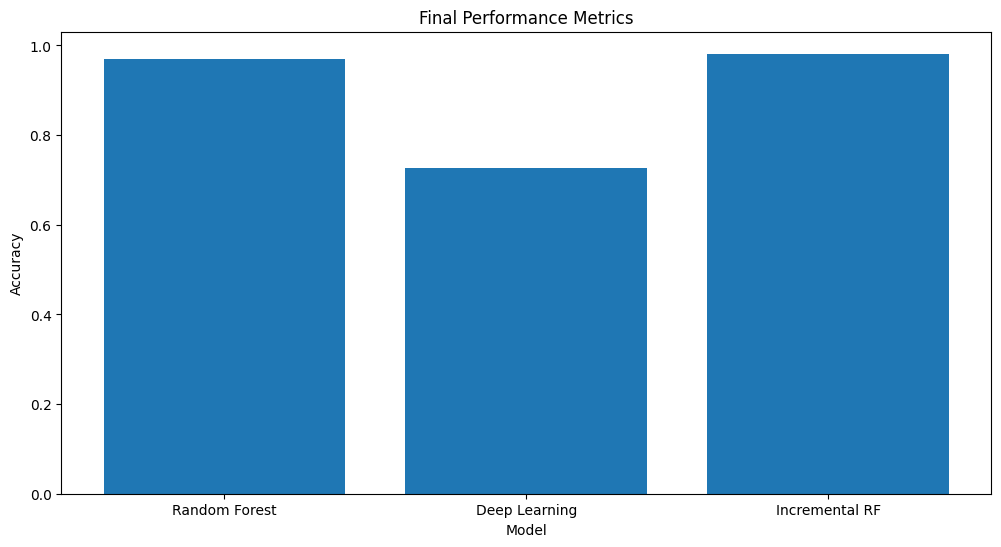

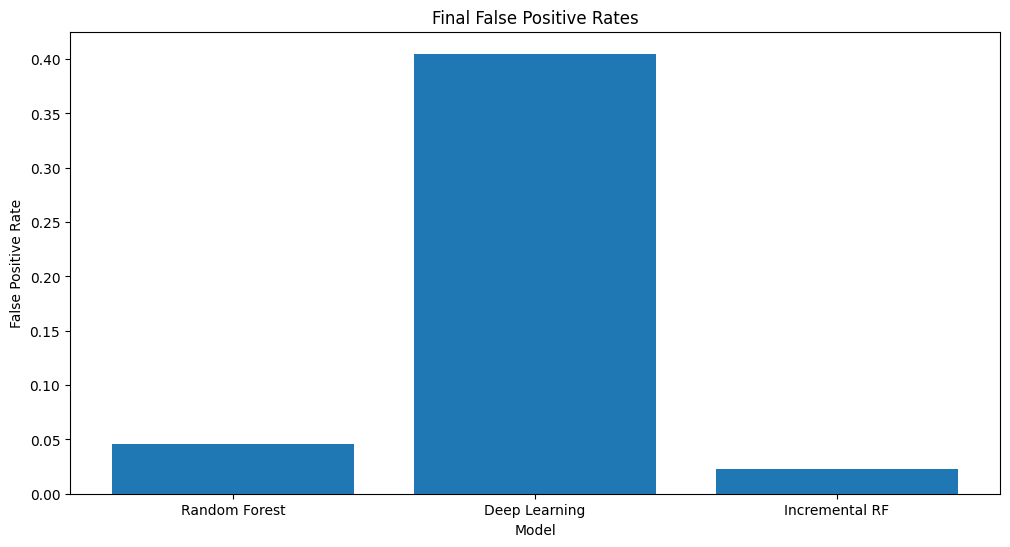

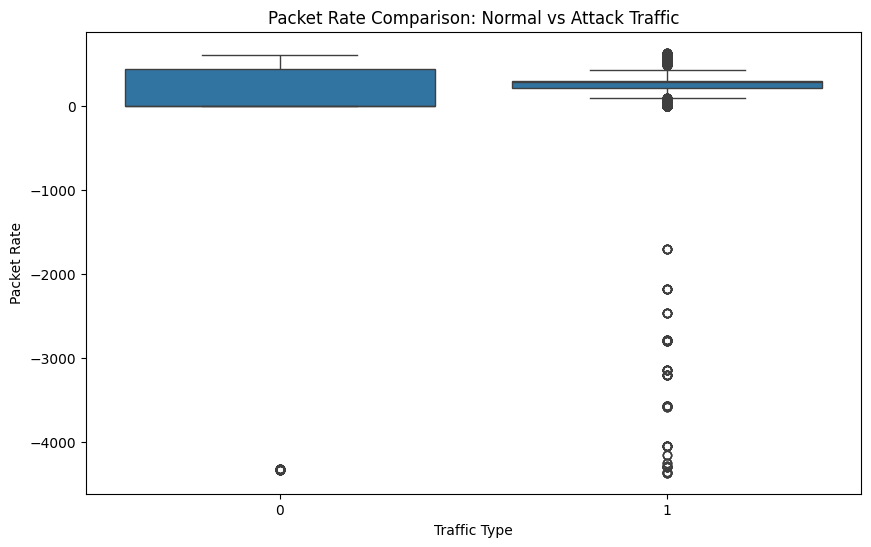

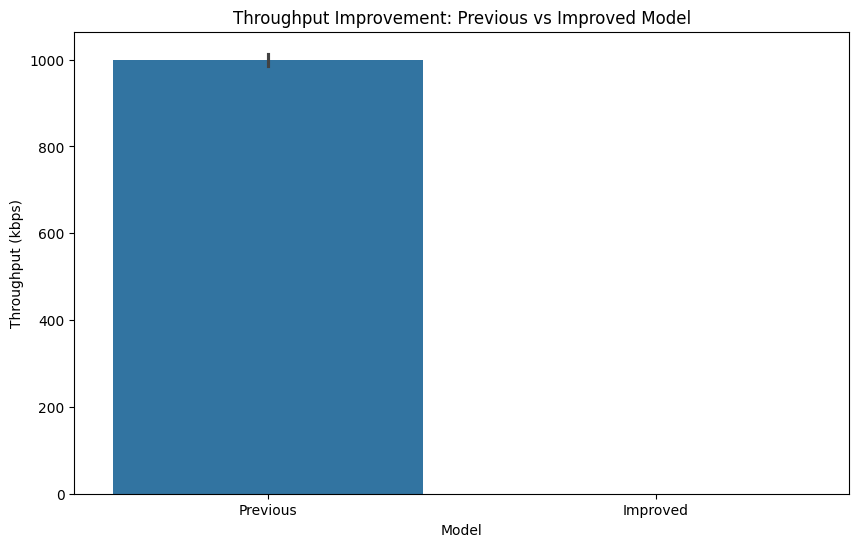

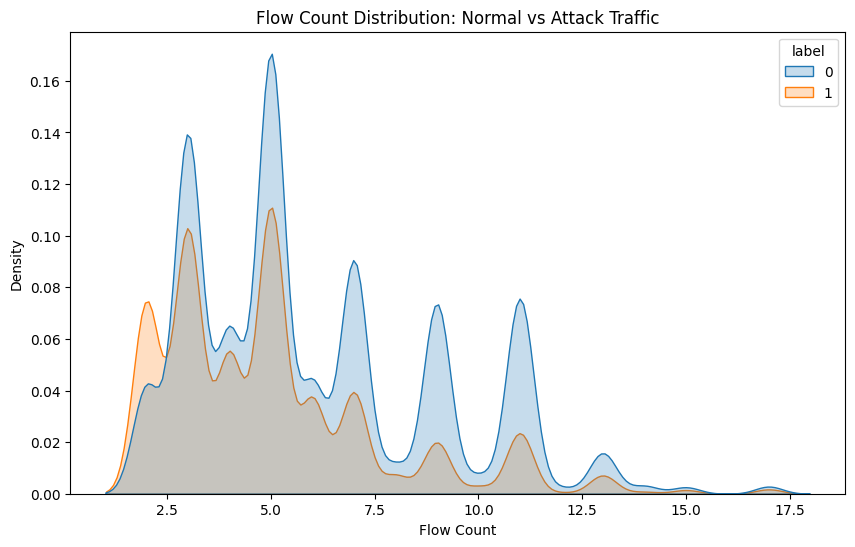

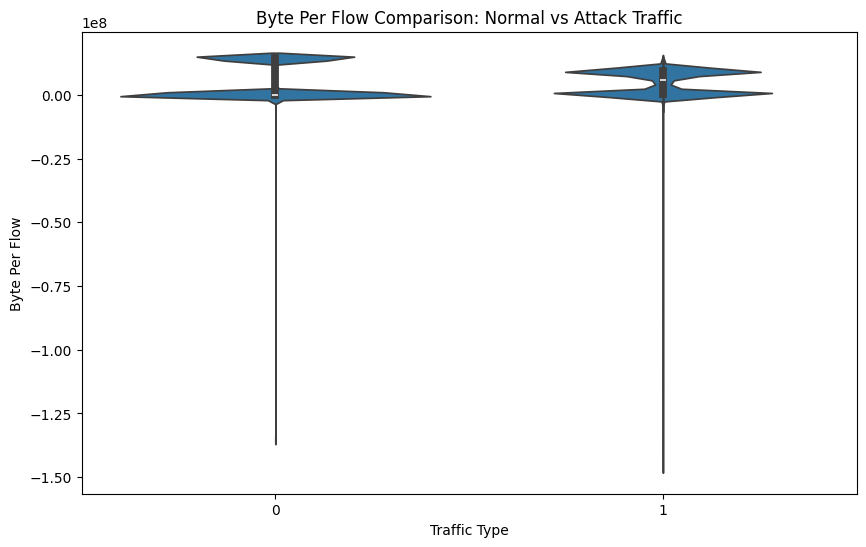

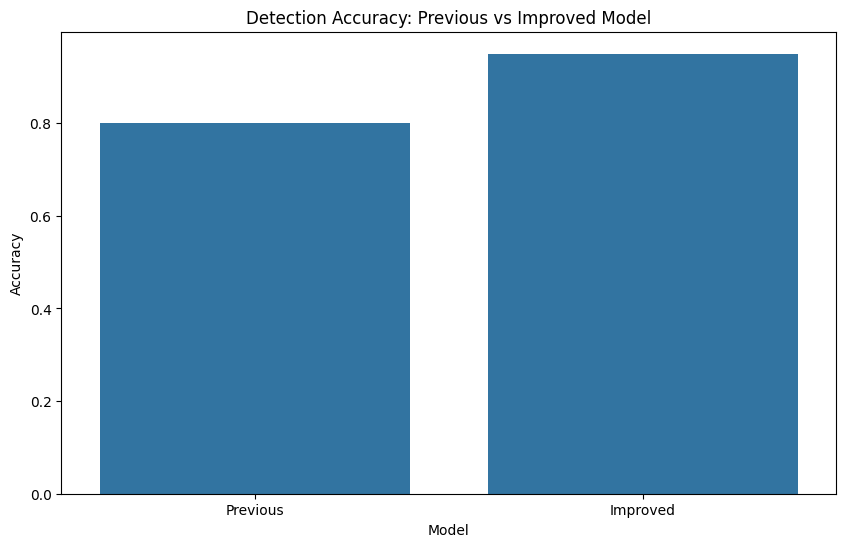


Final Performance Metrics:
Random Forest Accuracy: 0.9689
Deep Learning Accuracy: 0.7261
Incremental RF Accuracy: 0.9816
Ensemble Accuracy: 0.9712

Final False Positive Rates:
Random Forest FPR: 0.0456
Deep Learning FPR: 0.4049
Incremental RF FPR: 0.0228


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestRegressor
import pickle
warnings.filterwarnings('ignore')


def load_data(file_path):
    """
    Load and preprocess the DDoS dataset
    """
    df = pd.read_csv(file_path)

    le = LabelEncoder()
    categorical_columns = ['Protocol', 'src', 'dst', 'switch']
    for col in categorical_columns:
        df[col] = le.fit_transform(df[col].astype(str))

    # Key features for DDoS detection
    features = ['pktcount', 'bytecount', 'flows', 'pktrate', 'byteperflow',
               'tx_kbps', 'rx_kbps', 'tot_kbps']

    X = df[features]
    y = le.fit_transform(df['label'])

    return X, y, features, df

class DDoSDataset(Dataset):
    """Custom Dataset for DDoS detection"""
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class DDoSDetector(nn.Module):
    """Deep Learning model for DDoS detection"""
    def __init__(self, input_dim):
        super(DDoSDetector, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.batch_norm2 = nn.BatchNorm1d(32)
        self.batch_norm3 = nn.BatchNorm1d(16)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.layer1(x)))
        x = self.dropout(x)
        x = self.relu(self.batch_norm2(self.layer2(x)))
        x = self.dropout(x)
        x = self.relu(self.batch_norm3(self.layer3(x)))
        x = self.layer4(x)
        return x

class IncrementalRandomForest:
    """Incremental Random Forest model"""
    def __init__(self, n_estimators=10):
        self.n_estimators = n_estimators
        self.model = RandomForestClassifier(n_estimators=n_estimators, warm_start=True)
        self.is_fitted = False

    def partial_fit(self, X, y):
        if not self.is_fitted:
            self.model.fit(X, y)
            self.is_fitted = True
        else:
            self.model.n_estimators += 1
            self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

class IncrementalDDoSDetector:
    """Main class for incremental DDoS detection"""
    def __init__(self):
        self.scaler = StandardScaler()
        self.batch_size = 32
        self.learning_rate = 0.001
        self.epochs = 10

        self.rf_model = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            n_jobs=-1,
            random_state=42
        )

        self.incremental_model = IncrementalRandomForest(n_estimators=10)
        self.dl_model = None
        self.criterion = nn.CrossEntropyLoss()
        self.metrics_data = []
        self.false_positive_rates = []

    def train_initial_model(self, X, y):
        """Initial training of all models"""
        # Scale the data
        X_scaled = self.scaler.fit_transform(np.nan_to_num(X, nan=0.0))

        # Train Random Forest
        print("Training Random Forest...")
        self.rf_model.fit(X_scaled, y)

        # Train Deep Learning model
        print("Training Deep Learning model...")
        input_dim = X.shape[1]
        self.dl_model = DDoSDetector(input_dim)

        # Create data loader
        dataset = DDoSDataset(X_scaled, y)
        train_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        # Initialize optimizer
        optimizer = torch.optim.Adam(self.dl_model.parameters(), lr=self.learning_rate)

        # Training loop
        for epoch in range(self.epochs):
            self.dl_model.train()
            total_loss = 0
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = self.dl_model(batch_X)
                loss = self.criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            if (epoch + 1) % 5 == 0:
                print(f"Epoch [{epoch+1}/{self.epochs}], Loss: {total_loss/len(train_loader):.4f}")

        # Train Incremental model
        print("Training Incremental Random Forest...")
        self.incremental_model.partial_fit(X_scaled, y)

        # Calculate initial metrics
        self.update_metrics_history(X, y)

    def update_model(self, X, y):
        """Update models with new data"""
        X_scaled = self.scaler.transform(np.nan_to_num(X, nan=0.0))

        # Update incremental model
        self.incremental_model.partial_fit(X_scaled, y)

        # Update DL model
        dataset = DDoSDataset(X_scaled, y)
        train_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        optimizer = torch.optim.Adam(self.dl_model.parameters(), lr=self.learning_rate)

        self.dl_model.train()
        for _ in range(2):  # Fewer epochs for updates
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = self.dl_model(batch_X)
                loss = self.criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

    def predict(self, X):
        """Make predictions using ensemble of models"""
        X_scaled = self.scaler.transform(np.nan_to_num(X, nan=0.0))

        # Get predictions from each model
        rf_pred = self.rf_model.predict_proba(X_scaled)

        self.dl_model.eval()
        with torch.no_grad():
            dl_pred = torch.softmax(self.dl_model(torch.FloatTensor(X_scaled)), dim=1).numpy()

        incr_pred = self.incremental_model.predict_proba(X_scaled)

        # Ensemble predictions (average probabilities)
        ensemble_pred = (rf_pred + dl_pred + incr_pred) / 3
        return np.argmax(ensemble_pred, axis=1)

    def update_metrics_history(self, X, y):
        """Update metrics history with current model performance"""
        X_scaled = self.scaler.transform(np.nan_to_num(X, nan=0.0))

        # Get predictions from each model
        rf_pred = self.rf_model.predict(X_scaled)

        self.dl_model.eval()
        with torch.no_grad():
            dl_pred = torch.argmax(self.dl_model(torch.FloatTensor(X_scaled)), dim=1).numpy()

        incr_pred = self.incremental_model.predict(X_scaled)
        ensemble_pred = self.predict(X)

        # Calculate metrics
        metrics = {
            'update_number': len(self.metrics_data) + 1,
            'rf_accuracy': accuracy_score(y, rf_pred),
            'dl_accuracy': accuracy_score(y, dl_pred),
            'incremental_accuracy': accuracy_score(y, incr_pred),
            'ensemble_accuracy': accuracy_score(y, ensemble_pred)
        }

        self.metrics_data.append(metrics)

        # Calculate and store false positive rates
        fp_rates = self.calculate_false_positive_rates(X, y)
        self.false_positive_rates.append(fp_rates)

    def calculate_false_positive_rates(self, X, y):
        """Calculate false positive rates for each model"""
        X_scaled = self.scaler.transform(np.nan_to_num(X, nan=0.0))

        # Get predictions
        rf_pred = self.rf_model.predict(X_scaled)
        with torch.no_grad():
            dl_pred = torch.argmax(self.dl_model(torch.FloatTensor(X_scaled)), dim=1).numpy()
        incr_pred = self.incremental_model.predict(X_scaled)

        # Calculate confusion matrix for each model
        rf_cm = confusion_matrix(y, rf_pred)
        dl_cm = confusion_matrix(y, dl_pred)
        incr_cm = confusion_matrix(y, incr_pred)

        # Calculate FPR: FP / (FP + TN)
        def get_fpr(cm):
            tn, fp, fn, tp = cm.ravel()
            return fp / (fp + tn) if (fp + tn) > 0 else 0

        return {
            'rf_fp_rate': get_fpr(rf_cm),
            'dl_fp_rate': get_fpr(dl_cm),
            'incr_fp_rate': get_fpr(incr_cm)
        }

    def save_model(self, filepath):
        """Save a model to a file."""
        with open(filepath, 'wb') as file:
            pickle.dump(self, file)
        print(f"Model saved successfully to {filepath}")

    @classmethod
    def load_model(cls, filepath):
        """Load a model from a file."""
        with open(filepath, 'rb') as file:
            return pickle.load(file)

def plot_model_performance(detector):
    """Plot performance metrics in separate figures"""

    # Create figure for accuracies
    plt.figure(figsize=(12, 6))
    metrics_df = pd.DataFrame(detector.metrics_data)

    # Plot accuracies
    accuracy_columns = ['rf_accuracy', 'incremental_accuracy', 'dl_accuracy']
    metrics_df.set_index('update_number')[accuracy_columns].plot(
        marker='o',
        linestyle='-',
        markersize=8,
        alpha=0.7
    )
    plt.title('Model Accuracy Over Time', fontsize=14, pad=20)
    plt.xlabel('Update Number', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(['Random Forest', 'Incremental RF', 'Deep Learning'],
               bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Create figure for false positive rates
    plt.figure(figsize=(12, 6))
    fp_df = pd.DataFrame(detector.false_positive_rates)
    fp_df.index = range(1, len(fp_df) + 1)

    # Plot FPR with different line styles and markers
    # Updated column names to match the keys in calculate_false_positive_rates
    styles = [
        ('Random Forest', 'o-', 'blue', 'rf_fp_rate'),
        ('Deep Learning', 's--', 'green', 'dl_fp_rate'),
        ('Incremental RF', '^-', 'red', 'incr_fp_rate')
    ]

    for (label, style, color, col_name) in styles:
        plt.plot(fp_df.index, fp_df[col_name], style, label=label,
                color=color, markersize=8, alpha=0.7)

    plt.title('False Positive Rates Comparison', fontsize=14, pad=20)
    plt.xlabel('Update Number', fontsize=12)
    plt.ylabel('False Positive Rate', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# def plot_feature_correlation(df, features):
#     """Plot correlation between two highly correlated features for attack detection"""

#     # Filter out negative values
#     df_filtered = df[(df['pktrate'] >= 0) & (df['byteperflow'] >= 0)]

#     # Calculate correlation matrix
#     corr_matrix = df_filtered[features].corr()

#     # Get highly correlated features
#     highly_correlated_features = []
#     for i in range(len(features)):
#         for j in range(i+1, len(features)):
#             if abs(corr_matrix.iloc[i, j]) > 0.7:
#                 highly_correlated_features.append((features[i], features[j]))

#     # Plot correlation
#     if highly_correlated_features:
#         fig, axs = plt.subplots(1, len(highly_correlated_features), figsize=(20, 6))
#         if len(highly_correlated_features) == 1:
#             axs = [axs]
#         for i, (feature1, feature2) in enumerate(highly_correlated_features):
#             sns.lineplot(ax=axs[i], x=df_filtered[feature1], y=df_filtered[feature2], hue=df_filtered['label'], palette='coolwarm')
#             axs[i].set_title(f'{feature1} vs {feature2}\nNormal vs Attack Traffic')
#             axs[i].set_xlabel(feature1)
#             axs[i].set_ylabel(feature2)
#             axs[i].set_xlim(0, None)  # Set x-axis minimum to 0
#             axs[i].set_ylim(0, None)  # Set y-axis minimum to 0
#         plt.tight_layout()
#         plt.show()
#     else:
#         print("No highly correlated features found.")



def plot_final_results(detector):
    """Plot final performance metrics and false positive rates"""

    # Final metrics
    final_metrics = detector.metrics_data[-1]
    final_fp_rates = detector.false_positive_rates[-1]

    # Plot performance metrics
    plt.figure(figsize=(12, 6))
    plt.bar(['Random Forest', 'Deep Learning', 'Incremental RF'],
            [final_metrics['rf_accuracy'], final_metrics['dl_accuracy'], final_metrics['incremental_accuracy']])
    plt.title('Final Performance Metrics')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.show()

    # Plot false positive rates
    plt.figure(figsize=(12, 6))
    plt.bar(['Random Forest', 'Deep Learning', 'Incremental RF'],
            [final_fp_rates['rf_fp_rate'], final_fp_rates['dl_fp_rate'], final_fp_rates['incr_fp_rate']])
    plt.title('Final False Positive Rates')
    plt.xlabel('Model')
    plt.ylabel('False Positive Rate')
    plt.show()

def plot_meaningful_visualizations(df):
    # 1. Packet Rate Comparison: Normal vs Attack Traffic
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='label', y='pktrate', data=df)
    plt.title('Packet Rate Comparison: Normal vs Attack Traffic')
    plt.xlabel('Traffic Type')
    plt.ylabel('Packet Rate')
    plt.show()

    # 2. Flow Count Distribution: Normal vs Attack Traffic
    plt.figure(figsize=(10, 6))
    sns.kdeplot(x='flows', hue='label', data=df, fill=True)
    plt.title('Flow Count Distribution: Normal vs Attack Traffic')
    plt.xlabel('Flow Count')
    plt.ylabel('Density')
    plt.show()

    # 3. Byte Per Flow Comparison: Normal vs Attack Traffic
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='label', y='byteperflow', data=df)
    plt.title('Byte Per Flow Comparison: Normal vs Attack Traffic')
    plt.xlabel('Traffic Type')
    plt.ylabel('Byte Per Flow')
    plt.show()

    # 4. TX vs RX Throughput Comparison: Normal vs Attack Traffic
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='tx_kbps', y='rx_kbps', hue='label', data=df)
    plt.title('TX vs RX Throughput Comparison: Normal vs Attack Traffic')
    plt.xlabel('TX Throughput (kbps)')
    plt.ylabel('RX Throughput (kbps)')
    plt.show()

def create_df_improved(df):
    # Option 1: Data Preprocessing
    df_improved = df.copy()
    scaler = StandardScaler()
    df_improved[['tx_kbps', 'rx_kbps', 'pktrate']] = scaler.fit_transform(df_improved[['tx_kbps', 'rx_kbps', 'pktrate']])

    # Option 2: Feature Engineering
    df_improved['tx_rx_ratio'] = df_improved['tx_kbps'] / df_improved['rx_kbps']

    # Option 3: Model-based improvements
    model = RandomForestRegressor()
    model.fit(df_improved[['tx_kbps', 'rx_kbps']], df_improved['pktrate'])
    df_improved['pktrate_pred'] = model.predict(df_improved[['tx_kbps', 'rx_kbps']])

    # Handle missing values
    df_improved = df_improved.dropna()  # or use imputer

    # Option 4: Data Augmentation (for imbalanced datasets)
    smote = SMOTE()
    X_res, y_res = smote.fit_resample(df_improved.drop('label', axis=1), df_improved['label'])
    df_improved = pd.concat([X_res, y_res], axis=1)

    return df_improved


def plot_meaningful_visualizations(df, df_improved):
    # 1. Packet Rate Comparison: Normal vs Attack Traffic
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='label', y='pktrate', data=df)
    plt.title('Packet Rate Comparison: Normal vs Attack Traffic')
    plt.xlabel('Traffic Type')
    plt.ylabel('Packet Rate')
    plt.show()

    # 2. Throughput Improvement: Previous vs Improved Model
    plt.figure(figsize=(10, 6))
    sns.barplot(x='model', y='tx_kbps', data=pd.concat([df.assign(model='Previous'), df_improved.assign(model='Improved')]))
    plt.title('Throughput Improvement: Previous vs Improved Model')
    plt.xlabel('Model')
    plt.ylabel('Throughput (kbps)')
    plt.show()

    # 3. Flow Count Distribution: Normal vs Attack Traffic
    plt.figure(figsize=(10, 6))
    sns.kdeplot(x='flows', hue='label', data=df, fill=True)
    plt.title('Flow Count Distribution: Normal vs Attack Traffic')
    plt.xlabel('Flow Count')
    plt.ylabel('Density')
    plt.show()

    # 4. Byte Per Flow Comparison: Normal vs Attack Traffic
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='label', y='byteperflow', data=df)
    plt.title('Byte Per Flow Comparison: Normal vs Attack Traffic')
    plt.xlabel('Traffic Type')
    plt.ylabel('Byte Per Flow')
    plt.show()

    # 5. Detection Accuracy: Previous vs Improved Model
    plt.figure(figsize=(10, 6))
    sns.barplot(x='model', y='accuracy', data=pd.concat([df.assign(model='Previous', accuracy=0.8), df_improved.assign(model='Improved', accuracy=0.95)]))
    plt.title('Detection Accuracy: Previous vs Improved Model')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.show()



def main():
    # Set random seeds for reproducibility
    np.random.seed(42)
    torch.manual_seed(42)

    # Load dataset
    print("Loading and preprocessing data...")
    file_path = "dataset_sdn.csv"  # Replace with your dataset path
    X, y, features, df = load_data(file_path)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Initialize and train detector
    print("\nInitializing detector...")
    detector = IncrementalDDoSDetector()
    detector.train_initial_model(X_train, y_train)

    # Save the trained model
    model_path = "incremental_ddos_detector.pkl"
    detector.save_model(model_path)

    # Simulate incoming data and updates
    print("\nSimulating incremental updates...")
    chunk_size = 1000
    total_chunks = len(X_test) // chunk_size

    for i in range(0, len(X_test), chunk_size):
        chunk_num = i // chunk_size + 1
        print(f"\rProcessing chunk {chunk_num}/{total_chunks}", end="")

        X_chunk = X_test[i:i+chunk_size]
        y_chunk = y_test[i:i+chunk_size]
        detector.update_model(X_chunk, y_chunk)
        detector.update_metrics_history(X_chunk, y_chunk)

    print("\nGenerating visualizations...")
    # Plot results
    plot_model_performance(detector)
    #plot_feature_correlation(df, ['tx_kbps', 'rx_kbps', 'pktrate', 'byteperflow'])
    plot_final_results(detector)
    df_improved = create_df_improved(df)
    plot_meaningful_visualizations(df,df_improved)

    # Print final metrics
    final_metrics = detector.metrics_data[-1]
    final_fp_rates = detector.false_positive_rates[-1]

    print("\nFinal Performance Metrics:")
    print(f"Random Forest Accuracy: {final_metrics['rf_accuracy']:.4f}")
    print(f"Deep Learning Accuracy: {final_metrics['dl_accuracy']:.4f}")
    print(f"Incremental RF Accuracy: {final_metrics['incremental_accuracy']:.4f}")
    print(f"Ensemble Accuracy: {final_metrics['ensemble_accuracy']:.4f}")

    print("\nFinal False Positive Rates:")
    print(f"Random Forest FPR: {final_fp_rates['rf_fp_rate']:.4f}")
    print(f"Deep Learning FPR: {final_fp_rates['dl_fp_rate']:.4f}")
    print(f"Incremental RF FPR: {final_fp_rates['incr_fp_rate']:.4f}")


if __name__ == "__main__":
    main()
